# Practice: Information theory in Deep Learning.


## Question 1 Correlated Gaussian
#### (From Cover, T.M (1999). Elements of information theory. John Wiley & Sons)
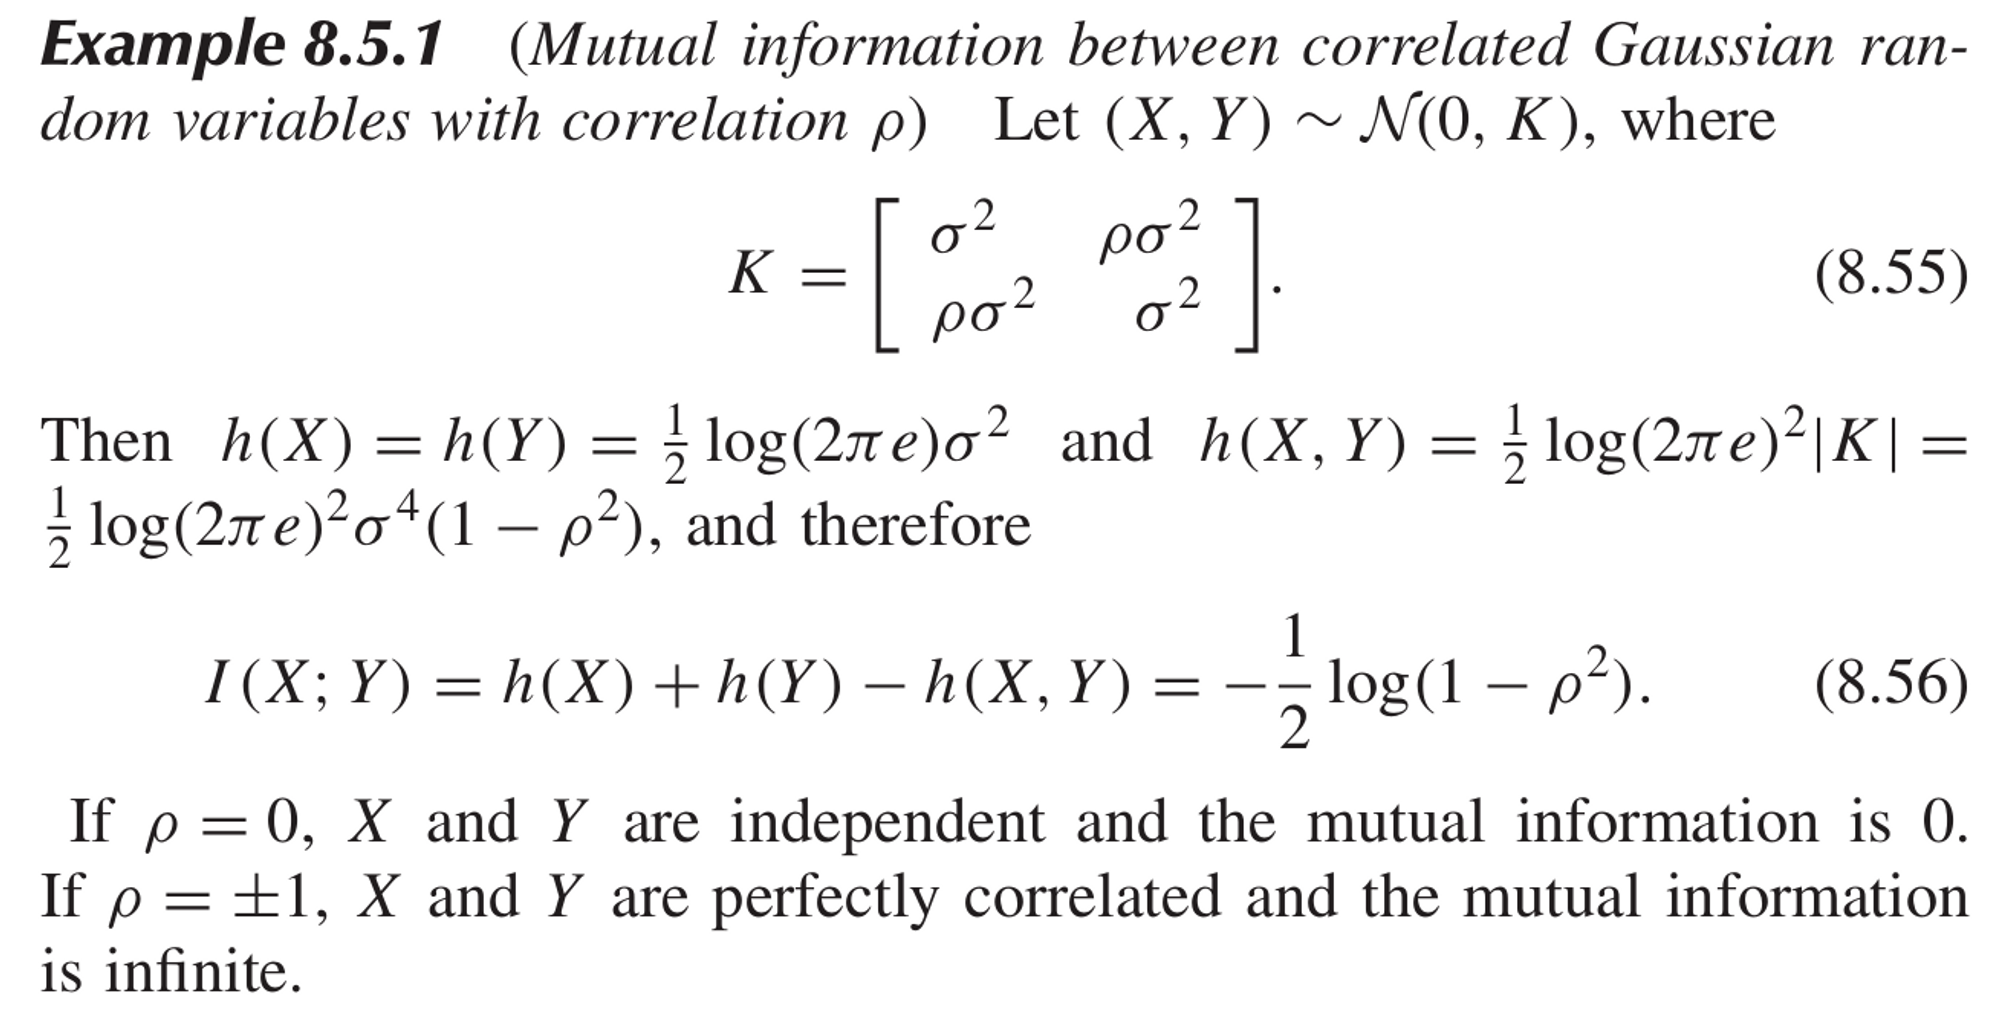
1. 코드에서 빈 부분을 채우세요.
2. 코드를 실행해서 결과를 얻으세요.
3. batch size 와 bound의 tightness (mi_true 와 측정한 값의 차이) 에 대해 분석하세요.

In [1]:
import os
!git clone https://github.com/ermongroup/smile-mi-estimator.git
os.rename('smile-mi-estimator', 'smile_mi_estimator')

Cloning into 'smile-mi-estimator'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 10), reused 24 (delta 8), pack-reused 0
Receiving objects: 100% (30/30), 1.01 MiB | 3.48 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
import numpy as np
import torch
from smile_mi_estimator.utils import SeparableCritic, sample_correlated_gaussian, mi_to_rho
from smile_mi_estimator.estimators import infonce_lower_bound

In [3]:
# 1.코드의 빈 부분을 채우세요.
dim = 20
for mi_true in [2,4,6,8,10]:
    for batch_size in [64,128,256]:
        critic = SeparableCritic(dim=dim, hidden_dim=256, embed_dim=32, layers=2, activation='relu').cuda()
        # critic = ConcatCritic(dim=dim, hidden_dim=256, layers=2, activation='relu').cuda()

        opt_crit = torch.optim.Adam(critic.parameters(), lr=5e-4)

        rho = mi_to_rho(dim, mi_true)

        mis = []
        for iii in range(2000):
            x, y = sample_correlated_gaussian(rho=rho, dim=dim, batch_size=batch_size, cubic=False)

            scores = critic(x.cuda(), y.cuda())
            mi = infonce_lower_bound(scores)

            loss = -mi

            opt_crit.zero_grad()
            loss.backward()
            opt_crit.step()

            mis.append(mi.item())

        print('MI (True): {0:.2f}, Batch Size: {1}, MI (Estimated): {2:.2f}'.format(mi_true, batch_size, np.mean(mis[-100:])))

# 2. 코드를 실행해서 결과를 얻으세요.

MI (True): 2.00, Batch Size: 64, MI (Estimated): 1.25
MI (True): 2.00, Batch Size: 128, MI (Estimated): 1.42
MI (True): 2.00, Batch Size: 256, MI (Estimated): 1.53
MI (True): 4.00, Batch Size: 64, MI (Estimated): 2.32
MI (True): 4.00, Batch Size: 128, MI (Estimated): 2.70
MI (True): 4.00, Batch Size: 256, MI (Estimated): 2.97
MI (True): 6.00, Batch Size: 64, MI (Estimated): 3.14
MI (True): 6.00, Batch Size: 128, MI (Estimated): 3.61
MI (True): 6.00, Batch Size: 256, MI (Estimated): 4.06
MI (True): 8.00, Batch Size: 64, MI (Estimated): 3.51
MI (True): 8.00, Batch Size: 128, MI (Estimated): 4.13
MI (True): 8.00, Batch Size: 256, MI (Estimated): 4.71
MI (True): 10.00, Batch Size: 64, MI (Estimated): 3.73
MI (True): 10.00, Batch Size: 128, MI (Estimated): 4.43
MI (True): 10.00, Batch Size: 256, MI (Estimated): 5.09


##### 3. batch size 와 bound의 tightness (mi_true 와 측정한 값의 차이) 에 대해 분석하세요.
batch size 가 큰 경우 좀 더 tight한 측정 값을 보여준다.
특히 infonce 가 측정할 수 있는 최대 mi 값이 log(batch_size) 이므로 log(batch_size) 보다 높은 mi 값을 측정하는 경우 상당히 loose 한 예측 값을 보여준다.

## Question 2. Alignment and Uniformity
1. 코드에서 빈 부분을 채우세요.
2. 코드를 실행해서 결과를 얻으세요.
3. randon init 모델과 pre-trained 모델의 alignment와 uniformity에 대해서 분석하세요.

In [4]:
import torch
import torchvision
import numpy as np

In [5]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input[0]
    def close(self):
        self.hook.remove()


class MultiTransform(object):
    def __init__(self, transform_list):
        self.transform_list = transform_list
    def __call__(self, input_img):
        return [each_transform(input_img) for each_transform in self.transform_list]


color_jitter = torchvision.transforms.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.4, hue = 0.1)
transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(size=32),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomApply([color_jitter], p=0.8),
            torchvision.transforms.RandomGrayscale(p=0.2),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
dataset_valid = torchvision.datasets.CIFAR10('./data/cifar10', train=False, transform=MultiTransform([transform]*2), target_transform=None, download=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, shuffle=False, pin_memory=True, batch_size = 256, num_workers=8)



def generate_representations_for_two_views(model, hook_reps, data_loader):
    rep0_list = []
    rep1_list = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            _ = model(inputs[0].to('cuda'))
            rep0_list.append(hook_reps.input)

            _ = model(inputs[1].to('cuda'))
            rep1_list.append(hook_reps.input)

    return torch.cat(rep0_list), torch.cat(rep1_list)

100%|██████████| 170498071/170498071 [00:11<00:00, 15265236.00it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# 1. 코드에서 빈 부분을 채우세요.
def align_loss(x, y, alpha=2):
    x = torch.nn.functional.normalize(x)
    y = torch.nn.functional.normalize(y)
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()

def uniform_loss(x, t=2):
    x = torch.nn.functional.normalize(x)
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

for model_name in ['resnet18','resnet34','resnet50','resnet101','resnet152']:
    for pretrained in [False, True]:
        model = torchvision.models.__dict__[model_name](pretrained=pretrained)
        model.eval()
        model.cuda()
        hook_fc = Hook(model.fc)

        alignment_loss, uniformity_loss = np.inf, np.inf
        while (not np.isfinite(alignment_loss)) or (not np.isfinite(uniformity_loss)):
            reps0, reps1 = generate_representations_for_two_views(model, hook_fc, loader_valid)
            alignment_loss = align_loss(reps0, reps1).item()
            uniformity_loss = uniform_loss(reps0).item()

        print('pretrained: {0}, model: {1}, align_loss: {2:.2f}, uniform_loss: {3:.2f}'.format(pretrained, model_name, alignment_loss, uniformity_loss))

# 2. 코드를 실행해서 결과를 얻으세요.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache

pretrained: False, model: resnet18, align_loss: 0.12, uniform_loss: -0.29


100%|██████████| 44.7M/44.7M [00:00<00:00, 88.4MB/s]


pretrained: True, model: resnet18, align_loss: 0.76, uniform_loss: -2.34
pretrained: False, model: resnet34, align_loss: 0.03, uniform_loss: -0.08


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.4MB/s]


pretrained: True, model: resnet34, align_loss: 0.66, uniform_loss: -2.06
pretrained: False, model: resnet50, align_loss: 0.02, uniform_loss: -0.05


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 316MB/s]


pretrained: True, model: resnet50, align_loss: 0.80, uniform_loss: -2.35
pretrained: False, model: resnet101, align_loss: 0.00, uniform_loss: -0.00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 294MB/s]


pretrained: True, model: resnet101, align_loss: 0.86, uniform_loss: -2.46
pretrained: False, model: resnet152, align_loss: 0.00, uniform_loss: -0.00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 95.6MB/s]


pretrained: True, model: resnet152, align_loss: 0.80, uniform_loss: -2.38


##### 3. randon init 모델과 pre-trained 모델의 alignment_loss와 uniformity_loss 대해서 비교 분석하세요.
random init 모델과 비교해서 pre-trained 모델의 alignment_loss는 확연히 작아진 것을 볼 수 있다.
학습을 통해 같은 정보를 가진 data가 unit hypersphere 상에서 가까운 공간의 representation들로 맵핑 되었다는 것을 알 수 있다.
uniformity_loss의 경우에는 aligmnemt와는 다른 경향을 볼 수 있다.
이것은 random init 모델이 representation을 random하게 공간에 맵핑 하기 때문에 uniformity가 처음부터 높기 때문이라고 볼 수 있다.